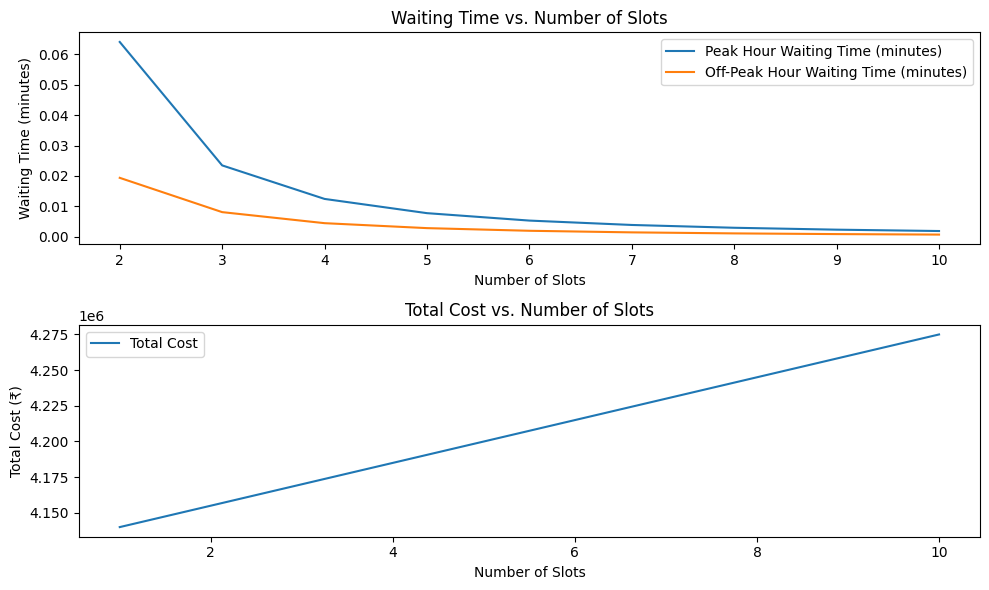

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
peak_hour_swaps = [5, 5, 10, 10, 5, 5]
off_peak_hour_swaps = [3, 2, 2, 2, 3, 3]
num_vehicles = 55
num_simulations = 1000
labor_cost_per_slot = 15000
battery_price = 75000
charging_time_hours = 2
swap_time_minutes = 10
num_slots_options = range(1, 11)  # Vary the number of slots from 1 to 10

# Calculate average arrival rates (vehicles per hour)
avg_lambda_peak = np.mean(peak_hour_swaps)
avg_lambda_off_peak = np.mean(off_peak_hour_swaps)

# Service rate (swaps per hour per slot)
mu = 60 / swap_time_minutes  # Converts swap time from minutes to swaps per hour

# Simulation function for waiting time (Wq) and total cost
def simulate(num_slots, lambda_peak, lambda_off_peak, mu, labor_cost_per_slot, battery_price):
    # Utilization rates
    rho_peak = lambda_peak / (mu * num_slots)
    rho_off_peak = lambda_off_peak / (mu * num_slots)
    
    # Calculate waiting time (Wq) using M/M/c formula
    if num_slots > 1:
        Wq_peak = (rho_peak / (mu * (num_slots - rho_peak))) if rho_peak < 1 else np.inf
        Wq_off_peak = (rho_off_peak / (mu * (num_slots - rho_off_peak))) if rho_off_peak < 1 else np.inf
    else:
        Wq_peak = Wq_off_peak = np.inf  # If only one slot, waiting time is very high
    
    # Total cost calculation
    total_labor_cost = labor_cost_per_slot * num_slots
    total_battery_cost = battery_price * num_vehicles
    total_cost = total_labor_cost + total_battery_cost
    
    return Wq_peak, Wq_off_peak, total_cost

# Perform simulations for different numbers of slots
results = []
for num_slots in num_slots_options:
    waiting_times_peak = []
    waiting_times_off_peak = []
    total_costs = []
    
    for _ in range(num_simulations):
        Wq_peak, Wq_off_peak, total_cost = simulate(
            num_slots, avg_lambda_peak, avg_lambda_off_peak, mu, labor_cost_per_slot, battery_price
        )
        waiting_times_peak.append(Wq_peak)
        waiting_times_off_peak.append(Wq_off_peak)
        total_costs.append(total_cost)
    
    avg_Wq_peak = np.mean(waiting_times_peak)
    avg_Wq_off_peak = np.mean(waiting_times_off_peak)
    avg_total_cost = np.mean(total_costs)
    
    results.append({
        'num_slots': num_slots,
        'avg_Wq_peak': avg_Wq_peak,
        'avg_Wq_off_peak': avg_Wq_off_peak,
        'avg_total_cost': avg_total_cost
    })

# Plot results
slots = [r['num_slots'] for r in results]
waiting_times_peak = [r['avg_Wq_peak'] for r in results]
waiting_times_off_peak = [r['avg_Wq_off_peak'] for r in results]
total_costs = [r['avg_total_cost'] for r in results]

plt.figure(figsize=(10, 6))

# Plot waiting time for peak hours
plt.subplot(2, 1, 1)
plt.plot(slots, waiting_times_peak, label='Peak Hour Waiting Time (minutes)')
plt.plot(slots, waiting_times_off_peak, label='Off-Peak Hour Waiting Time (minutes)')
plt.xlabel('Number of Slots')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Time vs. Number of Slots')
plt.legend()

# Plot total costs
plt.subplot(2, 1, 2)
plt.plot(slots, total_costs, label='Total Cost')
plt.xlabel('Number of Slots')
plt.ylabel('Total Cost (₹)')
plt.title('Total Cost vs. Number of Slots')
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import simpy

# Parameters
num_vehicles = 55          
battery_discharge_time = 12 # Time (hours) a battery lasts in use
swap_time = 10 / 60         # Battery swap time in hours (10 minutes)
num_slots = 3               # Number of battery swap slots available
simulation_duration = 24 * 7  # Simulate for 7 days (in hours)

# Track battery usage
battery_storage = []

class Vehicle:
    def __init__(self, env, vehicle_id, station):
        self.env = env
        self.vehicle_id = vehicle_id
        self.station = station
        self.action = env.process(self.run())  # Start vehicle process

    def run(self):
        swaps_per_vehicle = 5  # Limit swaps to 5
        swap_count = 0
        while swap_count < swaps_per_vehicle:
            # Vehicle uses a battery (discharge period)
            print(f"Vehicle {self.vehicle_id} is running at {self.env.now:.2f} hours.")
            yield self.env.timeout(battery_discharge_time)

            # Request battery swap
            print(f"Vehicle {self.vehicle_id} is requesting a battery swap at {self.env.now:.2f} hours.")
            with self.station.request() as request:
                yield request

                # Perform battery swap
                print(f"Vehicle {self.vehicle_id} is swapping the battery at {self.env.now:.2f} hours.")
                yield self.env.timeout(swap_time)

                # Track usage of charged batteries
                battery_storage.append(f"Vehicle {self.vehicle_id} swapped battery at {self.env.now:.2f} hours")

            swap_count += 1

# Define the simulation
def run_simulation(env, num_vehicles, station):
    vehicles = [Vehicle(env, i, station) for i in range(num_vehicles)]
    yield env.timeout(simulation_duration)  # Run for the specified duration

# Monte Carlo Simulation Function
def monte_carlo_simulation(num_vehicles, num_slots, trials=1):
    results = []
    for trial in range(trials):
        print(f"Starting trial {trial + 1}")
        env = simpy.Environment()
        station = simpy.Resource(env, capacity=num_slots)
        env.process(run_simulation(env, num_vehicles, station))
        env.run()
        results.append(len(battery_storage))  # Track number of batteries swapped
    return np.mean(results), np.std(results)

# Run the Monte Carlo simulation
mean_batteries, std_batteries = monte_carlo_simulation(num_vehicles, num_slots, trials=1)
print(f"Estimated average number of batteries swapped: {mean_batteries:.2f} +/- {std_batteries:.2f}")



Starting trial 1
Vehicle 0 is running at 0.00 hours.
Vehicle 1 is running at 0.00 hours.
Vehicle 2 is running at 0.00 hours.
Vehicle 3 is running at 0.00 hours.
Vehicle 4 is running at 0.00 hours.
Vehicle 5 is running at 0.00 hours.
Vehicle 6 is running at 0.00 hours.
Vehicle 7 is running at 0.00 hours.
Vehicle 8 is running at 0.00 hours.
Vehicle 9 is running at 0.00 hours.
Vehicle 10 is running at 0.00 hours.
Vehicle 11 is running at 0.00 hours.
Vehicle 12 is running at 0.00 hours.
Vehicle 13 is running at 0.00 hours.
Vehicle 14 is running at 0.00 hours.
Vehicle 15 is running at 0.00 hours.
Vehicle 16 is running at 0.00 hours.
Vehicle 17 is running at 0.00 hours.
Vehicle 18 is running at 0.00 hours.
Vehicle 19 is running at 0.00 hours.
Vehicle 20 is running at 0.00 hours.
Vehicle 21 is running at 0.00 hours.
Vehicle 22 is running at 0.00 hours.
Vehicle 23 is running at 0.00 hours.
Vehicle 24 is running at 0.00 hours.
Vehicle 25 is running at 0.00 hours.
Vehicle 26 is running at 0.00 h